# **Investment Portfolio Tracker**

In [1]:
import yfinance as yf
import pandas as pd

In [2]:
df = pd.read_excel('/Users/caitlynkay/Desktop/TransactionHistory.xlsx')
df.set_index('DATE', inplace=True)
df

,SYMBOL,ACTION,QTY,PRICE,FEE,TOTAL
DATE,,,,,,
2024-02-01,AMZN,BUY,1.0000,156.51,0.47,156.980000
2024-02-01,SHEL,BUY,2.0000,64.25,0.38,128.880000
2024-02-02,GOOG,BUY,1.0000,142.81,0.43,143.240000
2024-02-12,NVDA,BUY,0.2500,737.57,0.57,184.962500
2024-02-13,NVDA,BUY,0.2500,721.37,0.56,180.902500
2024-02-13,FVRR,BUY,3.0000,30.62,0.29,92.150000
2024-02-20,JEPI,BUY,2.0000,56.30,0.35,112.950000
2024-02-20,JEPQ,BUY,2.0000,52.03,0.70,104.760000
2024-03-12,MSTR,BUY,0.2000,1449.00,0.35,290.150000


In [3]:
stock_quant = df['ACTION'].map({'BUY': 1, 'SELL': -1}).mul(df['QTY']).groupby(df['SYMBOL']).sum().to_dict()

keys_to_remove = [key for key in stock_quant if stock_quant[key] == 0]
for key in keys_to_remove:
    del stock_quant[key]

stock_quant

{'AMZN': 1.0, 'FVRR': 3.0, 'GOOG': 1.0, 'NVDA': 0.5, 'SHEL': 2.0}

## **Average Stock Price**
#### Total purchase amount divided by the number of shares purchased

In [4]:
buydf = df[df['ACTION'] == 'BUY']
total_owned = buydf.groupby('SYMBOL')['TOTAL'].sum()
average_price = total_owned / buydf.groupby('SYMBOL')['QTY'].sum()
average_price.to_frame('AVG PRICE')


,AVG PRICE
SYMBOL,
AMZN,156.980000
FVRR,30.716667
GOOG,143.240000
JEPI,56.484985
JEPQ,52.396712
MSTR,1522.976471
NVDA,731.730000
SHEL,64.440000


## **Stocks Sold**
#### Total amount of stocks sold

In [5]:
selldf = df[df['ACTION'] == 'SELL']
total_sold = selldf.groupby('SYMBOL')['TOTAL'].sum()
total_sold.to_frame('TOTAL SOLD')

,TOTAL SOLD
SYMBOL,
JEPI,114.791725
JEPQ,106.409860
MSTR,2674.158000


## **Realized Profit**
#### Total amount of stocks sold minus quantity sold multiplied by average price

In [6]:
realized_profit = total_sold - selldf.groupby('SYMBOL')['QTY'].sum() * average_price
realized_profit.to_frame('REALIZED GAIN (LOSS)').dropna()

,REALIZED GAIN (LOSS)
SYMBOL,
JEPI,0.268418
JEPQ,0.385114
MSTR,85.098000


In [7]:
def getStockIndustry(symbol):
    stock = yf.Ticker(symbol)
    if (stock.info['quoteType'] == 'EQUITY'):
        stock_industry = stock.info['industry']
    else:
        stock_industry = stock.info['quoteType']
    return stock_industry

def getCurrentPrice(symbol):
    stock = yf.Ticker(symbol)
    if (stock.info['quoteType'] == 'EQUITY'):
        current_price = stock.info['currentPrice']
    else:
        current_price = stock.info['previousClose']
    return current_price

def getPreviousClosePrice(symbol):
    stock = yf.Ticker(symbol)
    previous_close = stock.info['previousClose']
    return previous_close

def getStockValue(symbol, quantity):
    stock_value = getCurrentPrice(symbol) * quantity
    return stock_value

def getPortfolioValue():
    total_value = sum(getStockValue(symbol, stock_quant[symbol]) for symbol in stock_quant)
    return total_value

def getStockPercentage(symbol, quantity):
    stock_value = getStockValue(symbol, quantity)
    percentage = stock_value/getPortfolioValue()*100
    return percentage

def getStockYearHighLow(symbol, value):
    stock = yf.Ticker(symbol)
    if value == 'high':
        year_value = stock.info['fiftyTwoWeekHigh']
    if value == 'low':
        year_value = stock.info['fiftyTwoWeekLow']
    return year_value

def getStockGainLoss(symbol):
    buydf = df[df['ACTION'] == 'BUY']
    totalowned = buydf.groupby('SYMBOL')['TOTAL'].sum()
    average_price[symbol] = getStockValue(symbol, stock_quant[symbol]) - totalowned[symbol]
    return average_price[symbol]

In [8]:
portfolio_dict = {'SYMBOL': [], 'INDUSTRY': [], 'PRICE': [], 'QTY': [],  'TOTAL': [], 'PERCENTAGE': [], 'DAY Δ': [], '52W HIGH': [], '52W LOW': [], 'GAIN (LOSS)': []}
for symbol in stock_quant:
    stock_industry = getStockIndustry(symbol)
    stock_price = getCurrentPrice(symbol)
    stock_value = getStockValue(symbol, stock_quant[symbol])
    percentage = getStockPercentage(symbol, stock_quant[symbol])
    day_change = stock_price-getPreviousClosePrice(symbol)
    year_high = getStockYearHighLow(symbol, 'high')
    year_low = getStockYearHighLow(symbol, 'low')
    stock_gainloss = getStockGainLoss(symbol)
        
    # Append stock information into portfolio_dict
    portfolio_dict['SYMBOL'].append(symbol)
    portfolio_dict['INDUSTRY'].append(stock_industry)
    portfolio_dict['PRICE'].append(stock_price)
    portfolio_dict['QTY'].append(stock_quant[symbol])
    portfolio_dict['TOTAL'].append(stock_value)
    portfolio_dict['PERCENTAGE'].append(percentage)
    portfolio_dict['DAY Δ'].append(day_change)
    portfolio_dict['52W HIGH'].append(year_high)
    portfolio_dict['52W LOW'].append(year_low)
    portfolio_dict['GAIN (LOSS)'].append(stock_gainloss)

## **Portfolio Summary**

In [9]:
portfoliodf = pd.DataFrame(data=portfolio_dict).sort_values(by='TOTAL', ascending=False)
portfoliodf.set_index('SYMBOL', inplace=True)
portfoliodf

,INDUSTRY,PRICE,QTY,TOTAL,PERCENTAGE,DAY Δ,52W HIGH,52W LOW,GAIN (LOSS)
SYMBOL,,,,,,,,,
NVDA,Semiconductors,1142.2950,0.5,571.1475,49.708441,3.2850,1149.390,373.560,205.528
AMZN,Internet Retail,182.9501,1.0,182.9501,15.923895,0.8001,191.700,118.350,25.980
GOOG,Internet Content & Information,177.8600,1.0,177.8600,15.480800,-0.1600,179.950,115.830,34.650
SHEL,Oil & Gas Integrated,71.4100,2.0,142.8200,12.427939,-0.3300,74.605,55.775,13.940
FVRR,Internet Content & Information,24.7500,3.0,74.2500,6.462855,-0.2800,34.490,18.830,-17.900


Total portfolio value: 1149.16


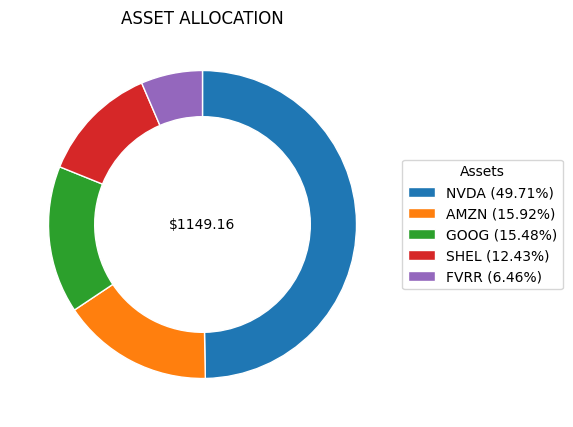

In [10]:
portfolio_value = getPortfolioValue()

plot = portfoliodf.plot.pie(y='PERCENTAGE',
                            title='ASSET ALLOCATION',
                            figsize=(5, 5),
                            legend=False,
                            wedgeprops=dict(width=0.3, edgecolor='w'),
                            startangle=90,
                            counterclock=False,
                            labels=None)

legend = [f'{idx} ({value:.2f}%)' for idx, value in zip(portfoliodf.index, portfoliodf['PERCENTAGE'].values)]

plot.legend(title='Assets',
            loc='center left',
            bbox_to_anchor=(1, 0, 0, 1),
            labels=legend)
plot.set_ylabel(ylabel=None)
plot.text(0, 0, f'${portfolio_value:.2f}', va = 'center', ha = 'center')

print(f'Total portfolio value: {portfolio_value:.2f}')

Total unrealized gain/loss: 262.20 (29.56%)


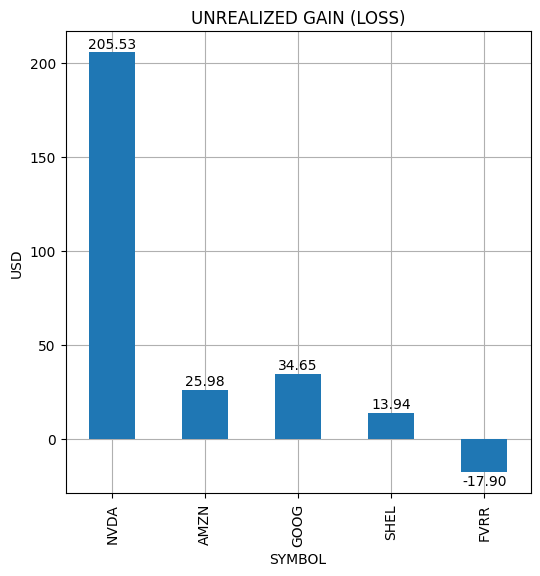

In [11]:
plot = portfoliodf.plot.bar(y='GAIN (LOSS)',
                            title='UNREALIZED GAIN (LOSS)',
                            figsize=(6, 6),
                            zorder=2,
                            legend=False)
plot.bar_label(plot.containers[0],
               fmt='%.2f',
               padding=1)
plot.set_ylabel('USD')
plot.grid(zorder=0)

gainloss = sum(portfoliodf['GAIN (LOSS)'].values)
percentgain = gainloss/(portfolio_value-gainloss)*100
print(f'Total unrealized gain/loss: {gainloss:.2f} ({percentgain:.2f}%)')
